# Lecture 03: Linear models (regression)

Objectives:
1. Reminder about regularized linear regression.
2. Use of different distributions for noise.
3. Numerical optimization for maximum likelihood estimation.

In [1]:
import numpy as np, matplotlib.pyplot as plt
import polars as pl
from sklearn.linear_model import Ridge
from scipy.special import beta

# Load data

Loading and simple cleanup.

In [2]:
df = (
    pl.read_csv("https://github.com/Michael-tehc/MachineLearning-MSU/raw/refs/heads/main/data/Housing.csv")
    .with_columns(
        pl.Series('dprice', list(np.random.binomial(1, 0.05, 545) * 2e7))
    )
    .with_columns(
        price=pl.col('price') + pl.col('dprice')
    )
)
df

price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus,dprice
f64,i64,i64,i64,i64,str,str,str,str,str,i64,str,str,f64
3.33e7,7420,4,2,3,"""yes""","""no""","""no""","""no""","""yes""",2,"""yes""","""furnished""",2e7
1.225e7,8960,4,4,4,"""yes""","""no""","""no""","""no""","""yes""",3,"""no""","""furnished""",0.0
1.225e7,9960,3,2,2,"""yes""","""no""","""yes""","""no""","""no""",2,"""yes""","""semi-furnished""",0.0
1.2215e7,7500,4,2,2,"""yes""","""no""","""yes""","""no""","""yes""",3,"""yes""","""furnished""",0.0
1.141e7,7420,4,1,2,"""yes""","""yes""","""yes""","""no""","""yes""",2,"""no""","""furnished""",0.0
…,…,…,…,…,…,…,…,…,…,…,…,…,…
1.82e6,3000,2,1,1,"""yes""","""no""","""yes""","""no""","""no""",2,"""no""","""unfurnished""",0.0
1.76715e6,2400,3,1,1,"""no""","""no""","""no""","""no""","""no""",0,"""no""","""semi-furnished""",0.0
2.175e7,3620,2,1,1,"""yes""","""no""","""no""","""no""","""no""",0,"""no""","""unfurnished""",2e7


In [3]:
# 1. Compute logarithms of price and area
# 2. Transform `yes/no` values to 1/0
df_clean = ...
df_clean

price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus,dprice
f64,f64,i64,i64,i64,bool,bool,bool,bool,bool,i64,bool,str,f64
17.321068,8.911934,4,2,3,true,false,false,false,true,2,true,"""furnished""",2e7
16.321036,9.100526,4,4,4,true,false,false,false,true,3,false,"""furnished""",0.0
16.321036,9.206332,3,2,2,true,false,true,false,false,2,true,"""semi-furnished""",0.0
16.318175,8.922658,4,2,2,true,false,true,false,true,3,true,"""furnished""",0.0
16.250001,8.911934,4,1,2,true,true,true,false,true,2,false,"""furnished""",0.0
…,…,…,…,…,…,…,…,…,…,…,…,…,…
14.414347,8.006368,2,1,1,true,false,true,false,false,2,false,"""unfurnished""",0.0
14.384879,7.783224,3,1,1,false,false,false,false,false,0,false,"""semi-furnished""",0.0
16.895124,8.194229,2,1,1,true,false,false,false,false,0,false,"""unfurnished""",2e7


In [4]:
FEATURE_NAMES = ['area', 'bedrooms', 'bathrooms', 'mainroad', 'basement']
X = df_clean.select(FEATURE_NAMES).to_numpy()
y = df_clean['price'].to_numpy()
X.shape, y.shape

((545, 5), (545,))

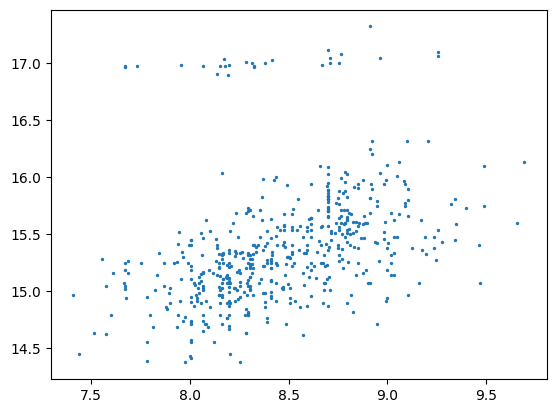

In [5]:
plt.scatter(X[:, 0], y, s=2);

In [ ]:
# Standardize the data
from sklearn.preprocessing import StandardScaler
X_standardized = ...

# Simple linear model: Gaussian noise + Ridge regularization

Semi-Bayesian formulation:
$$
\begin{aligned}
w &\sim \mathcal N\left( 0, \frac{1}{\lambda} I \right)\\
y_n &= b + x_n^\top w + \sigma \varepsilon_n, \quad \varepsilon_n \sim \mathcal N(0,1)
\end{aligned}
$$

A "truly Bayesian" formulation should have priors for $b \in \mathbb R$ and $\sigma > 0$.

Optimization problem:
$$
\begin{aligned}
\hat{b}, \hat w, \hat\sigma
&= \arg\min_{b,w,\sigma} \left[ -\sum_{n=1}^N \left(
 -\frac12 \ln(2\pi)
 -\ln \sigma - \frac12 \frac{(y_n - b - w^\top x_n)^2}{\sigma^2}
\right) + \lambda \frac12 \lVert w \rVert^2
\right]\\
&= \arg\min_{b,w,\sigma} \left[
 N\ln\sigma + \frac12 \frac{\lVert y - \mathbb 1 b - Xw \rVert^2}{\sigma^2} + \lambda \frac12 \lVert w \rVert^2
\right]
\end{aligned}
$$

Take derivatives:
$$
\begin{aligned}
\partial b &=-\sum_n (y_n - \mathbb 1 b - x_n^\top w) = 0\\
\nabla w &= -X^\top (y - \mathbb 1 b - Xw) + (\lambda I) w = 0\\
\partial \sigma &= \frac{N}{\sigma} - \frac{\lVert y - \mathbb 1 b - Xw \rVert^2}{\sigma^3} = 0
\end{aligned}
$$

## 1. Solve for $(b,w)$
Note that since $\sigma$ is the same for all observations, $(b,w)$ don't depend on $\sigma$! Otherwise we'd get _weighted_ linear regression.

Arrange into system of linear equations:
$$
\begin{aligned}
N b + \sum_n x_n^\top w &= \sum_n y_n\\
X^\top \mathbb 1 b + (X^\top X + \lambda I) w &= X^\top y
\end{aligned}
\implies
\underbrace{
\begin{bmatrix}
N & \sum_n x_n^\top\\
X^\top \mathbb 1 & X^\top X + \lambda I
\end{bmatrix}}_A
\begin{bmatrix}
b\\ w
\end{bmatrix}
= \begin{bmatrix}
\sum_n y_n\\
X^\top y
\end{bmatrix}
$$
Shape of the matrix $A$:
$$
\begin{aligned}
N &\in \mathbb R^{1 \times 1}\\
X^\top \mathbb 1 &\in \mathbb R^{F \times 1}\\
\sum_n x_n^\top &\in \mathbb R^{1 \times F}\\
X^\top X + \lambda I &\in \mathbb R^{F \times F}
\end{aligned}
$$
Thus, $A \in \mathbb R^{(F+1) \times (F+1)}$.

Solve this with `numpy.linalg.solve`, get estimates $(\hat b, \hat w)$.

## 2. Now that $(\hat b, \hat w)$ are known, solve for $\sigma$
$$
\hat\sigma = \sqrt{
 \frac1N \lVert y - \mathbb 1 \hat b - X \hat w \rVert^2
}
$$

In [6]:
def loglik_Gauss(params, X, y):
    N, F = X.shape
    b, w, sigma = params[0], params[1:F+1], params[F+1]
    residuals = (y - b - X @ w) / sigma
    return (
        -0.5 * np.log(2 * np.pi) - np.log(sigma) - 0.5 * residuals**2
    ).sum()

In [7]:
def solve_Gauss_ridge(X, y, lmb: float):
    N, F = X.shape
    assert y.shape == (N, )

    XT1 = X.sum(axis=0)
    # Matrix for system of linear equations
    A = np.empty((F+1, F+1))
    A[0, 0] = N
    A[1:, 0] = XT1
    A[0, 1:] = XT1
    A[1:, 1:] = X.T @ X + lmb * np.eye(F, F)
    # Vector for system of linear equations
    c = np.hstack([
        np.atleast_1d(y.sum()),
        X.T @ y
    ])

    # 1. Solve A.dot(bw) = c for (b, w)
    bw = ...
    b, w = ...
    # 2. Solve for sigma
    sigma = ...
    return b, w, sigma

In [8]:
class RidgeGauss:
    def __init__(self, lmb: float, feature_names: list[str]):
        assert lmb >= 0
        self.lmb = lmb
        self.feature_names = list(feature_names)

    def __repr__(self):
        df = pl.DataFrame({
            'name': ['bias', *self.feature_names, 'scale'],
            'value': [self.intercept_, *self.coef_, self.scale_]
        })
        with pl.Config(tbl_hide_column_data_types=True):
            return (
                f"RidgeGauss({self.lmb}) (AIC={self.aic_:.3f}):\n"
                f"{df}"
            )

    def fit(self, X, y):
        self.intercept_, self.coef_, self.scale_ = solve_Gauss_ridge(X, y, self.lmb)
        NPARAMS = 1 + len(self.coef_) + 1
        self.noise_ = (y - self.intercept_ - X @ self.coef_) / self.scale_
        self.aic_ = ...
        return self

In [9]:
RidgeGauss(0.0, FEATURE_NAMES).fit(X, y)

RidgeGauss(0.0) (AIC=701.230):
shape: (7, 2)
┌───────────┬───────────┐
│ name      ┆ value     │
╞═══════════╪═══════════╡
│ bias      ┆ 11.681575 │
│ area      ┆ 0.355891  │
│ bedrooms  ┆ 0.09472   │
│ bathrooms ┆ 0.186902  │
│ mainroad  ┆ 0.158751  │
│ basement  ┆ 0.118533  │
│ scale     ┆ 0.454548  │
└───────────┴───────────┘

In [10]:
(
    Ridge(0.0).fit(X, y).intercept_,
    Ridge(0.0).fit(X, y).coef_
)

(np.float64(11.681574719609165),
 array([0.35589118, 0.09472012, 0.18690216, 0.15875149, 0.11853336]))

In [11]:
RidgeGauss(100.0, FEATURE_NAMES).fit(X, y)

RidgeGauss(100.0) (AIC=724.285):
shape: (7, 2)
┌───────────┬───────────┐
│ name      ┆ value     │
╞═══════════╪═══════════╡
│ bias      ┆ 13.304161 │
│ area      ┆ 0.181922  │
│ bedrooms  ┆ 0.094401  │
│ bathrooms ┆ 0.128073  │
│ mainroad  ┆ 0.09192   │
│ basement  ┆ 0.073825  │
│ scale     ┆ 0.464264  │
└───────────┴───────────┘

In [12]:
Ridge(100.0).fit(X, y).intercept_ - RidgeGauss(100.0, FEATURE_NAMES).fit(X, y).intercept_

np.float64(-7.958078640513122e-13)

### Fit Ridge using standardized Xs

Use pipelines: https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html

In [ ]:
# Fit Ridge using standardized Xs
from sklearn.pipeline import Pipeline
Pipeline([
    ('scaler', StandardScaler()),
    ('ridge', Ridge(100))
]) # what next?

In [13]:
def how_regularization_affects_Gauss(X, y, feat_names: list[str], lambdas: np.ndarray):
    data = {
        'lambdas': []
    } | {
        name: [] for name in feat_names
    }
    for lmb in lambdas:
        model = RidgeGauss(lmb, feat_names).fit(X, y)
        data['lambdas'].append(lmb)
        for i, name in enumerate(feat_names):
            data[name].append(model.coef_[i])
    fig, ax = plt.subplots()
    ax.set_xlabel('Value of lambda')
    ax.set_ylabel('Value of coefficient')
    for name in feat_names:
        ax.plot(data['lambdas'], data[name], '.-', label=name)
    ax.legend(); ax.grid(True)
    return fig

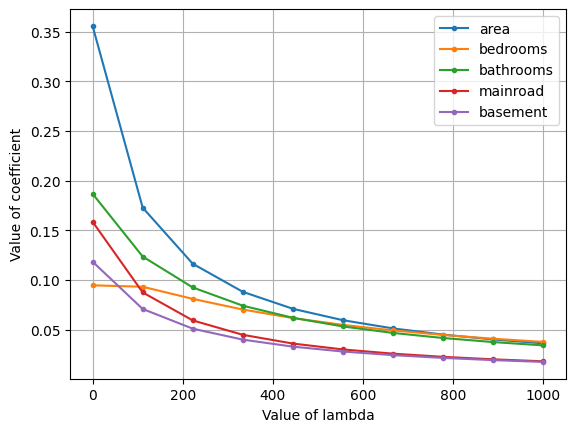

In [14]:
how_regularization_affects_Gauss(X, y, FEATURE_NAMES, np.linspace(0.01, 1000, 10));

In [15]:
def normal_pdf(x, mu, sigma):
    return np.exp(-0.5 * (x - mu)**2 / sigma**2) / np.sqrt(2 * np.pi) / sigma

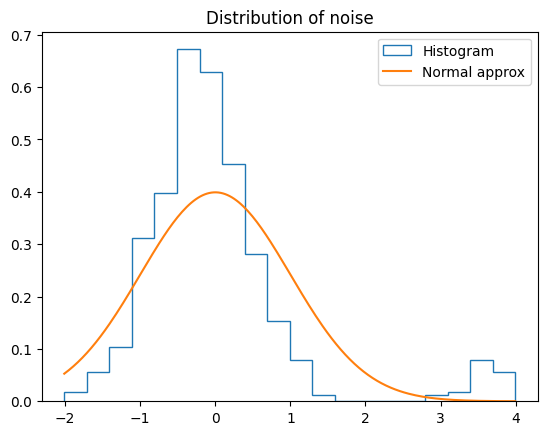

In [16]:
noise = RidgeGauss(100, FEATURE_NAMES).fit(X, y).noise_

possible_noises = np.linspace(noise.min(), noise.max(), 200)
plt.hist(noise, bins=20, histtype='step', density=True, label="Histogram")
plt.plot(possible_noises, normal_pdf(possible_noises, 0, 1), label="Normal approx")
plt.legend()
plt.title("Distribution of noise");

# Loss for Student t noise

Semi-Bayesian formulation:
$$
\begin{aligned}
w &\sim \mathcal N\left( 0, \frac{1}{\lambda} I \right)\\
y_n &= b + x_n^\top w + \sigma \varepsilon_n, \quad \varepsilon_n \sim \mathrm{Student}(\nu)
\end{aligned}
$$

__NOTE__: $\nu > 0$ is now a _parameter_ of the model!!

## Negative log-likelihood for single pair $(x_n, y_n)$

$$
-\ln p(y_n | x_n, b,w,\sigma,\nu) =
\ln\sigma + \frac{\ln\nu}{2} +
\ln B\left( \frac{\nu}2, \frac12 \right) -
\frac{1+\nu}2 \left[
\ln\nu - \ln\left(
 \nu + \frac{(y_n - b - x_n^\top w)^2}{\sigma^2}
\right)
\right],
$$
where $B\left( \frac{\nu}2, \frac12 \right)$ is the [Beta function](https://en.wikipedia.org/wiki/Beta_function).

The negative log-likelihood for the full dataset is a sum, as usual:
$$
\hat b, \hat w, \hat\sigma, \hat\nu = \arg\min -\sum_{n=1}^N \ln \left[
 \frac{1}{\sigma} p\left(
     \frac{y_n - b - x_n^\top w}{\sigma}; \nu
 \right)
\right] + \lambda \frac12 \lVert w \rVert^2
$$

__NOTE:__ $\sigma>0$ and $\nu > 0$, we must take this into account!

In [17]:
from dataclasses import dataclass

@dataclass
class Student:
    nu: float
    location: float=0.0
    scale: float=1.0

    def logpdf(self, x: np.ndarray):
        x = np.array(x)
        return (
            -np.log(self.scale) - np.log(self.nu)/2 - np.log(beta(self.nu/2, 1/2))
            + (1 + self.nu)/2 * (np.log(self.nu) - np.log(
                self.nu + (x - self.location)**2 / self.scale**2
            ))
        )

    def pdf(self, x):
        return np.exp(self.logpdf(x))

In [18]:
def loglik_Student(params: np.ndarray, X, y):
    params = np.array(params)
    N, F = X.shape
    b, w, sigma, nu = params[0], params[1:F+1], params[F+1], params[-1]
    if (sigma <= 0) or (nu <= 0):
        return -np.inf # Constraints are violated!!

    residuals = (y - b - X @ w) / sigma
    return (
        -np.log(sigma) - np.log(nu)/2 - np.log(beta(nu/2, 1/2))
        +(1 + nu)/2 * (np.log(nu) - np.log(nu + residuals**2))
    ).sum()

def nll_Student_penalized(params: np.ndarray, X, y, lmb=0):
    params = np.array(params)
    N, F = X.shape
    b, w, sigma, nu = params[0], params[1:F+1], params[F+1], params[-1]
    return -loglik_Student(params, X, y) + lmb/2 * np.linalg.norm(w)**2

In [19]:
X.shape

(545, 5)

In [20]:
loglik_Student(
    [
        1, # bias
        0,0,0,0,0, # weights
        10, # scale
        200, # nu
    ], X, y
)

np.float64(-2321.6016464866443)

In [21]:
# Nudge one of the parameters to increase log-likelihood
loglik_Student(
    [
        y.mean(), # bias
        0,0,0,0,0, # weights
        10, # scale
        200, # nu
    ],
    X, y
)

np.float64(-1757.1461760668367)

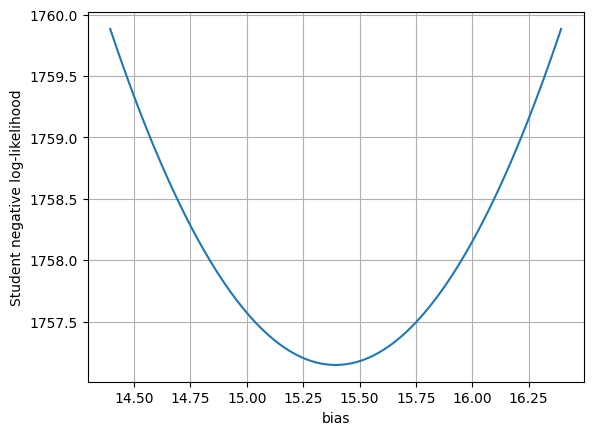

In [22]:
nll = lambda bias: -loglik_Student(
    [
        bias,
        0,0,0,0,0, # weights
        10, # scale
        200, # nu
    ], X, y
)
biases = np.linspace(y.mean() - 1, y.mean() + 1, 100)
plt.plot(
    biases, np.vectorize(nll)(biases)
);
plt.xlabel('bias'); plt.ylabel('Student negative log-likelihood'); plt.grid();

# Minimize _any_ loss function via hill climbing

```
And if I only could
I'd make a deal with God
And I'd get Him to swap our places
Be runnin' up that road
Be runnin' up that hill...
```

"Hill climbing" is for _maximization_, but we're _minimizing_, so we'll try to roll down that valley.

In [23]:
np.eye(1, 4, 0)[0,:], np.eye(1,4, 1)[0,:], np.eye(1,4, 2)[0,:]

(array([1., 0., 0., 0.]), array([0., 1., 0., 0.]), array([0., 0., 1., 0.]))

In [24]:
def generate_neighbors(params: np.ndarray, step_size: float):
    params = np.array(params)
    D = len(params)
    return [
        params + sign * step_size * np.eye(1, D, d)[0, :]
        for d in range(D)
        for sign in [-1, +1]
    ]

In [25]:
generate_neighbors([0.3, 2, -1], 0.1)

[array([ 0.2,  2. , -1. ]),
 array([ 0.4,  2. , -1. ]),
 array([ 0.3,  1.9, -1. ]),
 array([ 0.3,  2.1, -1. ]),
 array([ 0.3,  2. , -1.1]),
 array([ 0.3,  2. , -0.9])]

In [42]:
def min_hillclimb(loss, params: np.ndarray, step_size: float, niter: int, print_each=5000, quiet=True):
    assert step_size > 0
    params = np.array(params)
    
    loss_history = [loss(params)]
    for iteration in range(niter):
        if not quiet and (iteration % print_each == 0):
            print(f"{iteration=:>4d}, loss={loss_history[-1]:.4f}")

        lowest_loss, best_neighbor = ..., ...

        loss_history.append(lowest_loss)
        params[:] = best_neighbor

    if not quiet: print(f"{iteration=:>5d}, loss={loss_history[-1]:.4f}")
    return params, np.array(loss_history)

iteration=   0, loss=4.6239
iteration= 100, loss=3.7921
iteration= 200, loss=3.0553
iteration= 300, loss=2.3527
iteration= 400, loss=1.6538
iteration= 500, loss=0.9670
iteration= 600, loss=0.3464
iteration= 700, loss=0.0000
iteration= 800, loss=0.0000
iteration= 900, loss=0.0000
iteration=  999, loss=0.0000

Optimum:
	x   =[-4.09915157e-14 -1.42247325e-16  4.57620053e-15]
	f(x)=4.1246408425858946e-14


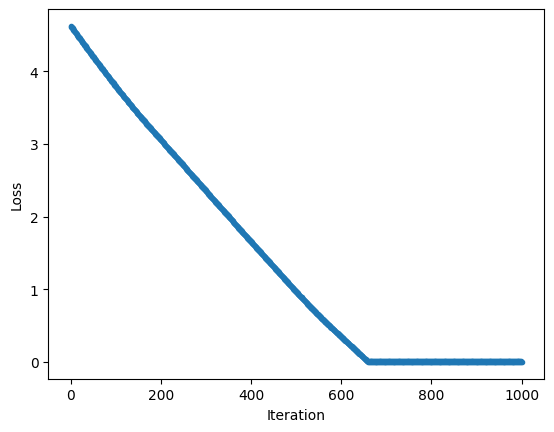

In [43]:
xopt, losses = min_hillclimb(
    lambda x: np.linalg.norm(x),
    [-4, .3, 2.3],
    0.01, 1000, print_each=100, quiet=False
)
print(f"\nOptimum:\n\tx   ={xopt}\n\tf(x)={losses[-1]}")
plt.plot(losses, '.'); plt.xlabel('Iteration'); plt.ylabel('Loss');

In [28]:
def generate_neighbors_stoch(params: np.ndarray, step_size: float):
    params = np.array(params)
    D = len(params)
    signs = np.random.choice([-1, 1], size=D)
    return [
        params + sign * step_size * np.eye(1, D, d)[0, :]
        for sign, d in zip(signs, range(D))
    ]

In [29]:
generate_neighbors_stoch([0,1,2], .1)

[array([-0.1,  1. ,  2. ]), array([0. , 0.9, 2. ]), array([0. , 1. , 1.9])]

In [30]:
generate_neighbors_stoch([0,1,2], .1)

[array([0.1, 1. , 2. ]), array([0. , 0.9, 2. ]), array([0. , 1. , 2.1])]

In [40]:
def min_hillclimb_stoch(loss, params: np.ndarray, step_size: float, niter: int, print_each=5000, quiet=True):
    assert step_size > 0
    params = np.array(params)
    
    loss_history = [loss(params)]
    for iteration in range(niter):
        ...
    return params, np.array(loss_history)

## Hill climbing for Student regression

iteration=   0, loss=1759.8847
iteration=5000, loss=387.7905
iteration=10000, loss=386.8152
iteration=15000, loss=386.1047
iteration=20000, loss=385.1148
iteration=25000, loss=383.6341
iteration=30000, loss=380.8996
iteration=35000, loss=374.3622
iteration=40000, loss=344.7445
iteration=45000, loss=298.1382
iteration=49999, loss=298.1382
shape: (8, 2)
┌───────────┬───────────┐
│ names     ┆ values    │
│ ---       ┆ ---       │
│ str       ┆ f64       │
╞═══════════╪═══════════╡
│ bias      ┆ 15.373863 │
│ area      ┆ -0.12     │
│ bedrooms  ┆ 0.095     │
│ bathrooms ┆ 0.29      │
│ mainroad  ┆ 0.325     │
│ basement  ┆ 0.1       │
│ scale     ┆ 0.265     │
│ nu        ┆ 2.455     │
└───────────┴───────────┘


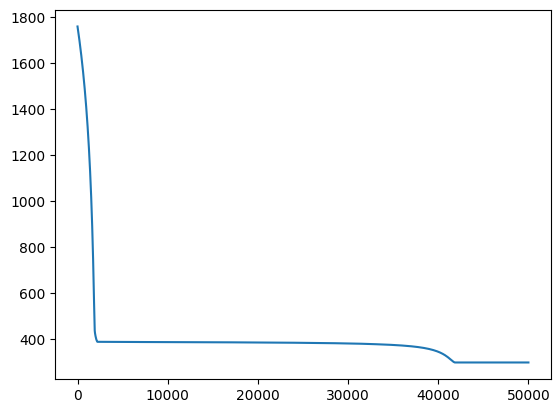

In [44]:
params_opt_hillclimb, losses_hillclimb = min_hillclimb(
    lambda par: nll_Student_penalized(par, X, y, 100),
    [
        1 + y.mean(), # bias
        0,0,0,0,0, # weights
        10, # scale
        200, # nu
    ],
    0.005, 50_000, quiet=False
)
print(pl.DataFrame({
    'names': ['bias', *FEATURE_NAMES, 'scale', 'nu'],
    'values': params_opt_hillclimb
}))
plt.plot(losses_hillclimb);

iteration=   0, loss=1759.8847
iteration=5000, loss=370.7504
iteration=10000, loss=370.7456
iteration=15000, loss=370.7502
iteration=20000, loss=370.7522
iteration=25000, loss=370.7523
iteration=30000, loss=370.7433
iteration=35000, loss=370.7489
iteration=40000, loss=370.7512
iteration=45000, loss=370.7449
iteration=49999, loss=370.7462
shape: (8, 2)
┌───────────┬───────────┐
│ names     ┆ values    │
│ ---       ┆ ---       │
│ str       ┆ f64       │
╞═══════════╪═══════════╡
│ bias      ┆ 14.768863 │
│ area      ┆ -0.01     │
│ bedrooms  ┆ 0.08      │
│ bathrooms ┆ 0.2       │
│ mainroad  ┆ 0.205     │
│ basement  ┆ 0.105     │
│ scale     ┆ 0.47      │
│ nu        ┆ 199.915   │
└───────────┴───────────┘


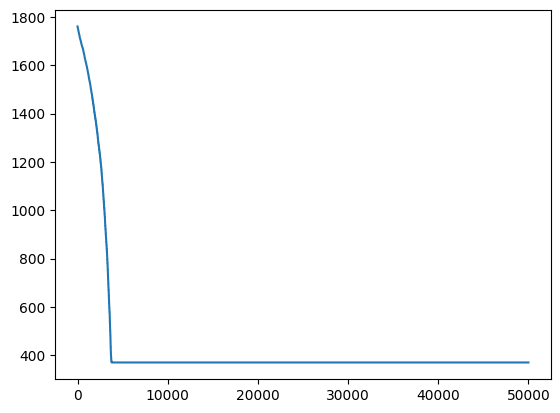

In [45]:
params_opt_hillclimb_stoch, losses_hillclimb_stoch = min_hillclimb_stoch(
    lambda par: nll_Student_penalized(par, X, y, 100),
    [
        1 + y.mean(), # bias
        0,0,0,0,0, # weights
        10, # scale
        200, # nu
    ],
    0.005, 50_000, quiet=False
)
print(pl.DataFrame({
    'names': ['bias', *FEATURE_NAMES, 'scale', 'nu'],
    'values': params_opt_hillclimb_stoch
}))
plt.plot(losses_hillclimb_stoch);

## Full implementation of Student regression

In [34]:
class RidgeStudent:
    def __init__(
        self, lmb: float, feature_names: list[str],
        step_size: float=0.005, niter: int=50_000
    ):
        assert lmb >= 0
        assert step_size > 0
        assert niter > 0
        self.lmb = lmb
        self.feature_names = list(feature_names)
        self.step_size, self.niter = step_size, niter

    def __repr__(self):
        df = pl.DataFrame({
            'name': ['bias', *self.feature_names, 'scale', 'nu'],
            'value': [self.intercept_, *self.coef_, self.scale_, self.nu_]
        })
        with pl.Config(tbl_hide_column_data_types=True):
            return (
                f"{self.__class__.__name__}({self.lmb}) (AIC={self.aic_:.3f}):\n"
                f"{df}"
            )

    def fit(self, X, y):
        N, F = X.shape
        params_opt, losses = min_hillclimb(
            lambda par: nll_Student_penalized(par, X, y, self.lmb),
            [
                y.mean(), # bias
                *np.zeros(F), # weights
                y.std(), # scale
                200, # nu
            ],
            self.step_size, self.niter
        )
        self.intercept_, self.coef_, self.scale_, self.nu_ = (
            params_opt[0], params_opt[1:F+1], params_opt[F+1], params_opt[-1]
        )
        self.loss_ = losses[-1]
        self.noise_ = (y - self.intercept_ - X @ self.coef_) / self.scale_
        self.aic_ = -2 * loglik_Student(params_opt, X, y) + 2 * len(params_opt)
        return self

In [35]:
RidgeGauss(100, FEATURE_NAMES).fit(X, y)

RidgeGauss(100) (AIC=724.285):
shape: (7, 2)
┌───────────┬───────────┐
│ name      ┆ value     │
╞═══════════╪═══════════╡
│ bias      ┆ 13.304161 │
│ area      ┆ 0.181922  │
│ bedrooms  ┆ 0.094401  │
│ bathrooms ┆ 0.128073  │
│ mainroad  ┆ 0.09192   │
│ basement  ┆ 0.073825  │
│ scale     ┆ 0.464264  │
└───────────┴───────────┘

In [36]:
RidgeStudent(100, FEATURE_NAMES).fit(X, y)

RidgeStudent(100) (AIC=514.674):
shape: (8, 2)
┌───────────┬───────────┐
│ name      ┆ value     │
╞═══════════╪═══════════╡
│ bias      ┆ 14.463863 │
│ area      ┆ -0.005    │
│ bedrooms  ┆ 0.085     │
│ bathrooms ┆ 0.28      │
│ mainroad  ┆ 0.3       │
│ basement  ┆ 0.1       │
│ scale     ┆ 0.237909  │
│ nu        ┆ 2.26      │
└───────────┴───────────┘

In [37]:
RidgeStudent(100, FEATURE_NAMES, step_size=0.01).fit(X, y)

RidgeStudent(100) (AIC=524.069):
shape: (8, 2)
┌───────────┬───────────┐
│ name      ┆ value     │
╞═══════════╪═══════════╡
│ bias      ┆ 14.533863 │
│ area      ┆ 0.0       │
│ bedrooms  ┆ 0.06      │
│ bathrooms ┆ 0.27      │
│ mainroad  ┆ 0.27      │
│ basement  ┆ 0.1       │
│ scale     ┆ 0.247909  │
│ nu        ┆ 2.37      │
└───────────┴───────────┘

In [38]:
RidgeStudent(100, FEATURE_NAMES, step_size=0.1).fit(X, y)

RidgeStudent(100) (AIC=604.123):
shape: (8, 2)
┌───────────┬───────────┐
│ name      ┆ value     │
╞═══════════╪═══════════╡
│ bias      ┆ 14.893863 │
│ area      ┆ 0.0       │
│ bedrooms  ┆ 0.0       │
│ bathrooms ┆ 0.2       │
│ mainroad  ┆ 0.2       │
│ basement  ┆ 0.1       │
│ scale     ┆ 0.317909  │
│ nu        ┆ 3.2       │
└───────────┴───────────┘

Note that $\nu\approx 2$, so the corresponding Student distribution is far away from Gaussian (when $\nu\to\infty$).

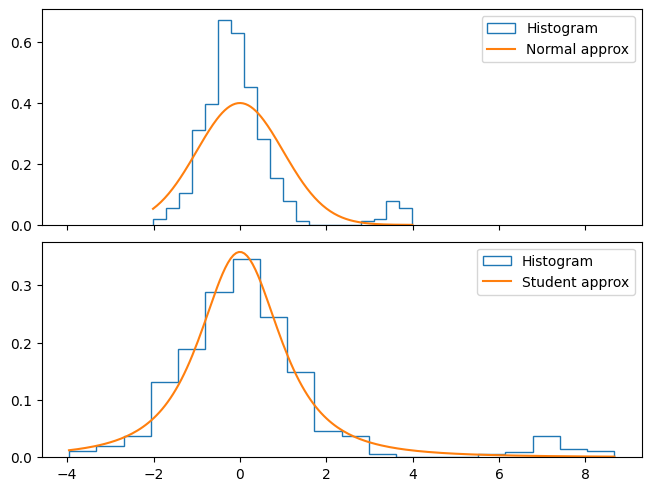

In [39]:
noise_Gauss = RidgeGauss(100, FEATURE_NAMES).fit(X, y).noise_
model_Student = RidgeStudent(100, FEATURE_NAMES).fit(X, y)
noise_Student = model_Student.noise_

fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True, layout='constrained')
ax1.hist(noise_Gauss, bins=20, histtype='step', density=True, label="Histogram")
possible_noises = np.linspace(noise_Gauss.min(), noise_Gauss.max(), 200)
ax1.plot(possible_noises, normal_pdf(possible_noises, 0, 1), label="Normal approx")
ax1.legend()

ax2.hist(noise_Student, bins=20, histtype='step', density=True, label="Histogram")
possible_noises = np.linspace(noise_Student.min(), noise_Student.max(), 200)
ax2.plot(possible_noises, Student(model_Student.nu_).pdf(possible_noises), label="Student approx")
ax2.legend()
fig;